# Load Libraries and set global variables

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import torch
import utils
from chronos import ChronosPipeline
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder

FORECAST_HORIZON = 17

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [4]:
# read data frame and parse dates as datetime
df = pd.read_csv('data/data.csv', parse_dates=['delivery_week'])

# create a masked df due to confidential data
masked_df = df.copy()
masked_df[['target', 'marketing_events_1', 'marketing_events_2']] = MinMaxScaler().fit_transform(masked_df[['target', 'marketing_events_1', 'marketing_events_2']])
masked_df[['unique_id']] = OrdinalEncoder().fit_transform(masked_df[['unique_id']])

print(f"Distinct number of time series: {len(masked_df['unique_id'].unique())}")
masked_df.head()

Distinct number of time series: 195


,unique_id,delivery_week,country,target,marketing_events_1,marketing_events_2
0,0.0,2018-12-31,us,0.017484,0.072103,0.262909
1,0.0,2019-01-07,us,0.026652,0.042019,0.456050
2,0.0,2019-01-14,us,0.025160,0.040776,0.407437
3,0.0,2019-01-21,us,0.027505,0.040030,0.368940
4,0.0,2019-01-28,us,0.028571,0.034063,0.339640


# Split data between train and test

In [5]:
# Let's use the last 17 weeks of actuals as of today for the holdout set and the remaining data for the forecast
forecast_df = df[df['delivery_week'] < "2023-10-16"]
holdout_df = df[(df['delivery_week'] >= "2023-10-16") & (df['delivery_week'] <= "2024-02-05")]

# since we have several time series not all of them have the same number of weeks in the forecast set
print(f"Weeks for training: {len(forecast_df['delivery_week'].unique())} from {min(forecast_df['delivery_week']).date()} to {max(forecast_df['delivery_week']).date()}")
print(f"Weeks for testing: {len(holdout_df['delivery_week'].unique())} from {min(holdout_df['delivery_week']).date()} to {max(holdout_df['delivery_week']).date()}")

Weeks for training: 250 from 2018-12-31 to 2023-10-09
Weeks for testing: 17 from 2023-10-16 to 2024-02-05


# Forecast

In [ ]:
# load model
pipeline_tiny = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-tiny",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

pipeline_large = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

# run forecast
forecast_tiny = []
forecast_large = []
for ts in forecast_df["unique_id"].unique():
    # tiny
    lower, mid, upper = utils.chronos_forecast(pipeline_tiny, forecast_df[forecast_df['unique_id'] == ts], FORECAST_HORIZON)
    forecast_tiny.append(utils.convert_forecast_to_pandas([lower, mid, upper], holdout_df[holdout_df['unique_id'] == ts]))
    
    # large
    lower, mid, upper = utils.chronos_forecast(pipeline_large, forecast_df[forecast_df['unique_id'] == ts], FORECAST_HORIZON)
    forecast_large.append(utils.convert_forecast_to_pandas([lower, mid, upper], holdout_df[holdout_df['unique_id'] == ts]))

# convert list to data frames
forecast_tiny = pd.concat(forecast_tiny)
forecast_large = pd.concat(forecast_large)

## Plot Actuals and Forecast

In [ ]:
# get series ordered by volume in a descending way
series = holdout_df.groupby('unique_id')['target'].sum().reset_index().sort_values(by='target', ascending=False)['unique_id'].tolist()

for ts in series[:6]:
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_tiny[forecast_tiny["unique_id"] == ts], ts)
    utils.plot_actuals_forecast(df[df["unique_id"]==ts], forecast_large[forecast_large["unique_id"] == ts], ts)

# Model Evaluation

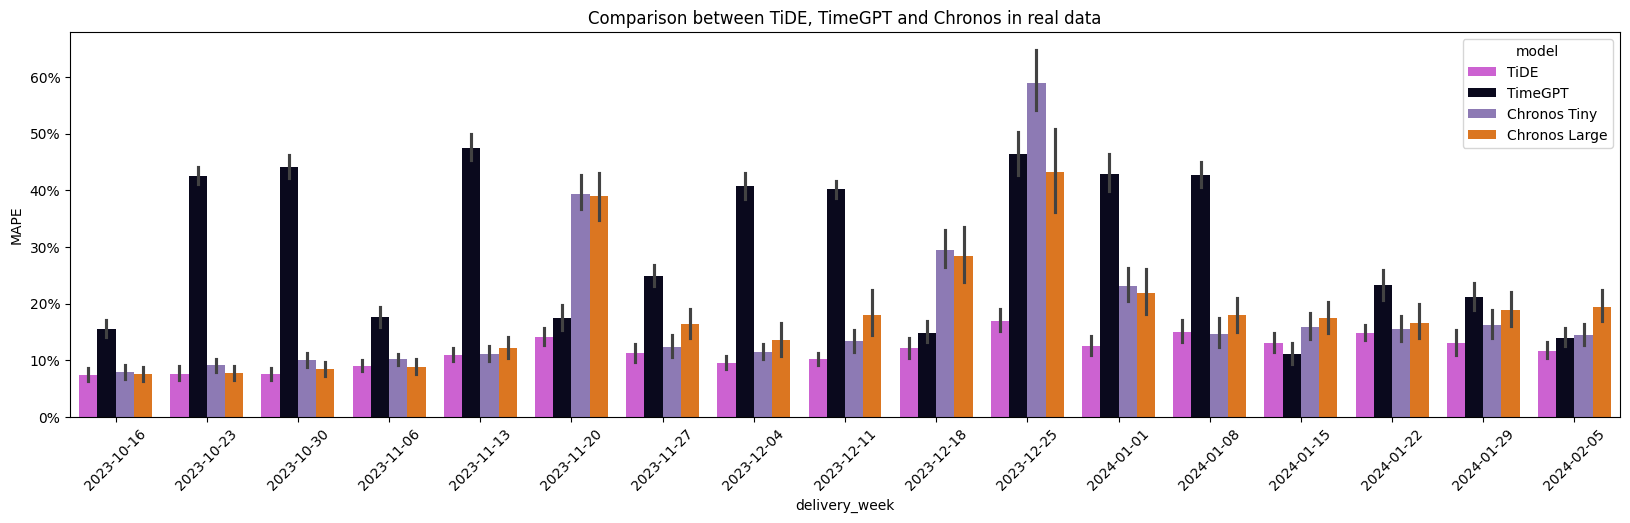

In [6]:
# load the forecast from our current model in production
tide_model_df = pd.read_csv('data/tide.csv', parse_dates=['delivery_week'])
timegpt_model_df = pd.read_csv('data/timegpt.csv', parse_dates=['delivery_week'])
chronos_tiny_df = pd.read_csv('data/chronos_tiny.csv', parse_dates=['delivery_week'])
chronos_large_df = pd.read_csv('data/chronos_large.csv', parse_dates=['delivery_week'])

# merge data frames with forecast and actuals
model_eval_df = pd.merge(holdout_df[['unique_id', 'delivery_week', 'target']], tide_model_df[['unique_id', 'delivery_week', 'forecast']], on=['unique_id', 'delivery_week'], how='inner')
model_eval_df = pd.merge(model_eval_df, timegpt_model_df[['unique_id', 'delivery_week', 'TimeGPT']], on=['unique_id', 'delivery_week'], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_tiny_df[['unique_id', 'delivery_week', 'Chronos Tiny']], on=['unique_id', 'delivery_week'], how='inner')
model_eval_df = pd.merge(model_eval_df, chronos_large_df[['unique_id', 'delivery_week', 'Chronos Large']], on=['unique_id', 'delivery_week'], how='inner')

utils.plot_model_comparison(model_eval_df)